In [38]:
import cPickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

def convert_images(vector):
    """
    Convert images from the CIFAR-10 format and
    return a 4-dim array with shape: [image_number, height, width, channel]
    where the pixels are floats between 0.0 and 1.0.
    """

    # Reshape the array to 4-dimensions.
    images = vector.reshape([3, 32, 32, -1])
    
    #images = vector.reshape([-1, 3, 32, 32])

    # Reorder the indices of the array.
    images = images.transpose([1, 2, 0, 3])
    #images = images.transpose([0, 2, 3, 1])

    return images

In [39]:
# Load cnn predicted train and test data
predicted_train = np.load('predictedTrain_cifar_ncols_16.npy')
predicted_test = np.load('predictedTest_cifar_ncols_16.npy')

print predicted_train.shape
print predicted_test.shape

(3072, 50000)
(3072, 10000)


In [46]:
train_images = convert_images(predicted_train)
print train_images.shape

(32, 32, 3, 50000)


In [40]:
temp = predicted_test.T
print temp.shape

(10000, 3072)


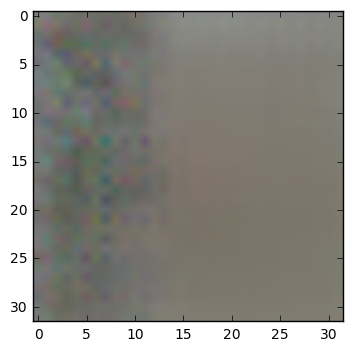

In [52]:
plt.imshow(train_images[:, :, :, 5000])

In [ ]:
|